In [1]:
!pip install fasttext scikit-learn pandas imbalanced-learn --quiet

import pandas as pd
import numpy as np
import fasttext
import fasttext.util
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, roc_auc_score,
    classification_report, ConfusionMatrixDisplay, RocCurveDisplay
)
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import os
import joblib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 2.0 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
fasttext.util.download_model('pl', if_exists='ignore')

'cc.pl.300.bin'

In [3]:
ft_model = fasttext.load_model('cc.pl.300.bin')

In [4]:
def get_ft_vector(text):
    return ft_model.get_sentence_vector(text)

In [ ]:
def prepare_data(train_path, test_path, smote=True):
    train_df = pd.read_csv(train_path)
    test_df = pd.read_csv(test_path)

    X_train = np.vstack(train_df['text'].apply(get_ft_vector))
    y_train = train_df['label'].values
    X_test = np.vstack(test_df['text'].apply(get_ft_vector))
    y_test = test_df['label'].values

    if smote:
        sm = SMOTE(random_state=42)
        X_train, y_train = sm.fit_resample(X_train, y_train)

    print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")
    print(f"Class distribution in train after SMOTE: {np.bincount(y_train)}")

    return X_train, y_train, X_test, y_test

In [ ]:
def train_and_evaluate_rf(X_train, y_train, X_test, y_test, param_grid, model_name="rf_model", verbose=2):
    rf = RandomForestClassifier(random_state=42)
    cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

    grid_search = GridSearchCV(
        rf,
        param_grid,
        cv=cv,
        scoring='f1',
        n_jobs=-1,
        verbose=verbose
    )

    print("Start strojenia hiperparametrów...")
    grid_search.fit(X_train, y_train)

    print("\nNajlepsze parametry:", grid_search.best_params_)
    print(f"Najlepszy wynik F1 z walidacji krzyżowej: {grid_search.best_score_:.4f}")

    best_rf = grid_search.best_estimator_

    y_pred = best_rf.predict(X_test)
    y_proba = best_rf.predict_proba(X_test)[:, 1]

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)

    print("\n=== Evaluation Metrics (Final Model on Test Set) ===")
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-score:  {f1:.4f}")
    print(f"ROC-AUC:   {roc_auc:.4f}")

    print("\nClassification Report:\n")
    print(classification_report(y_test, y_pred, zero_division=0))

    os.makedirs("RF_results", exist_ok=True)

    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix for RF - The Best Variant")
    plt.savefig(f"RF_results/{model_name}_confusion_matrix.png")
    plt.show()

    RocCurveDisplay.from_predictions(y_test, y_proba)
    plt.title("ROC Curve for RF - The Best Varianl")
    plt.savefig(f"RF_results/{model_name}_roc_curve.png")
    plt.show()

    joblib.dump(best_rf, f"RF_results/{model_name}.joblib")
    print(f"Model zapisany jako: RF_results/{model_name}.joblib")

In [7]:
param_grid_rf = {
    'n_estimators': [300, 400],
    'max_depth': [10, 15],
    'min_samples_split': [5, 10],
    'min_samples_leaf': [3, 5],
    'max_features': ['sqrt'],
    'class_weight': ['balanced']
}

In [8]:
def run_pipeline(train_path, test_path, smote=True, param_grid=param_grid_rf):
    X_train, y_train, X_test, y_test = prepare_data(train_path, test_path, smote=smote)
    train_and_evaluate_rf(X_train, y_train, X_test, y_test, param_grid)

Train shape: (18380, 300), Test shape: (1000, 300)
Class distribution in train after SMOTE: [9190 9190]
Start strojenia hiperparametrów...
Fitting 4 folds for each of 16 candidates, totalling 64 fits

Najlepsze parametry: {'class_weight': 'balanced', 'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 300}
Najlepszy wynik F1 z walidacji krzyżowej: 0.9674

=== Evaluation Metrics (Final Model on Test Set) ===
Accuracy:  0.8980
Precision: 0.7424
Recall:    0.3657
F1-score:  0.4900
ROC-AUC:   0.9003

Classification Report:

              precision    recall  f1-score   support

           0       0.91      0.98      0.94       866
           1       0.74      0.37      0.49       134

    accuracy                           0.90      1000
   macro avg       0.83      0.67      0.72      1000
weighted avg       0.89      0.90      0.88      1000



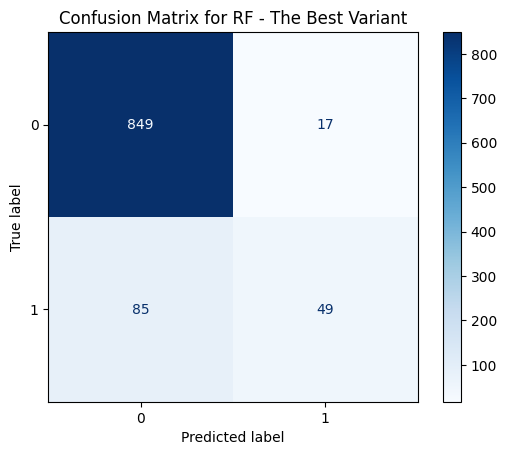

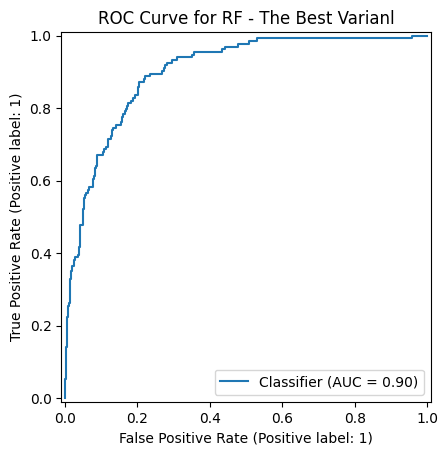

Model zapisany jako: RF_results/rf_model.joblib


In [9]:
run_pipeline("v1_training_variant1_raw.csv", "v1_test_variant1_raw.csv", smote=True)

Train shape: (18380, 300), Test shape: (1000, 300)
Class distribution in train after SMOTE: [9190 9190]
Start strojenia hiperparametrów...
Fitting 4 folds for each of 16 candidates, totalling 64 fits

Najlepsze parametry: {'class_weight': 'balanced', 'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 400}
Najlepszy wynik F1 z walidacji krzyżowej: 0.9674

=== Evaluation Metrics (Final Model on Test Set) ===
Accuracy:  0.8920
Precision: 0.6806
Recall:    0.3657
F1-score:  0.4757
ROC-AUC:   0.9062

Classification Report:

              precision    recall  f1-score   support

           0       0.91      0.97      0.94       866
           1       0.68      0.37      0.48       134

    accuracy                           0.89      1000
   macro avg       0.79      0.67      0.71      1000
weighted avg       0.88      0.89      0.88      1000



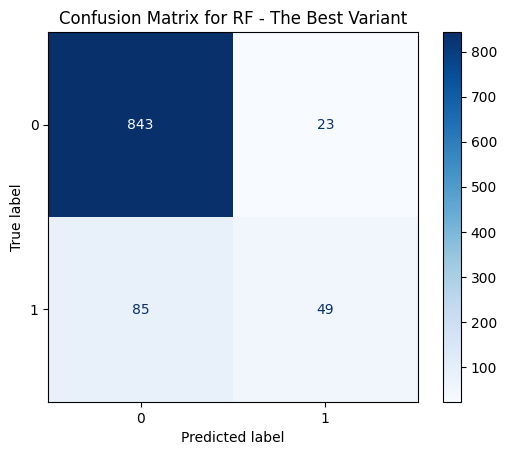

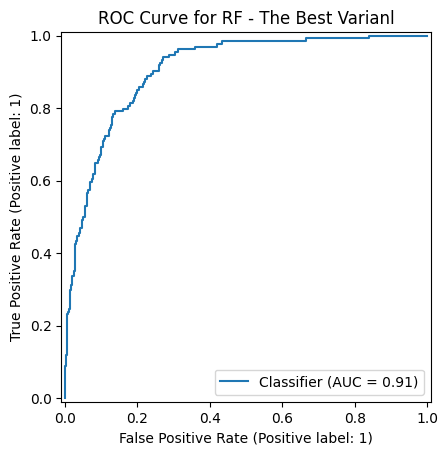

Model zapisany jako: RF_results/rf_model.joblib


In [10]:
run_pipeline("v1_training_variant2_light.csv", "v1_test_variant2_light.csv", smote=True)

Train shape: (18314, 300), Test shape: (999, 300)
Class distribution in train after SMOTE: [9157 9157]
Start strojenia hiperparametrów...
Fitting 4 folds for each of 16 candidates, totalling 64 fits

Najlepsze parametry: {'class_weight': 'balanced', 'max_depth': 15, 'max_features': 'sqrt', 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 400}
Najlepszy wynik F1 z walidacji krzyżowej: 0.9614

=== Evaluation Metrics (Final Model on Test Set) ===
Accuracy:  0.8879
Precision: 0.6341
Recall:    0.3881
F1-score:  0.4815
ROC-AUC:   0.8847

Classification Report:

              precision    recall  f1-score   support

           0       0.91      0.97      0.94       865
           1       0.63      0.39      0.48       134

    accuracy                           0.89       999
   macro avg       0.77      0.68      0.71       999
weighted avg       0.87      0.89      0.88       999



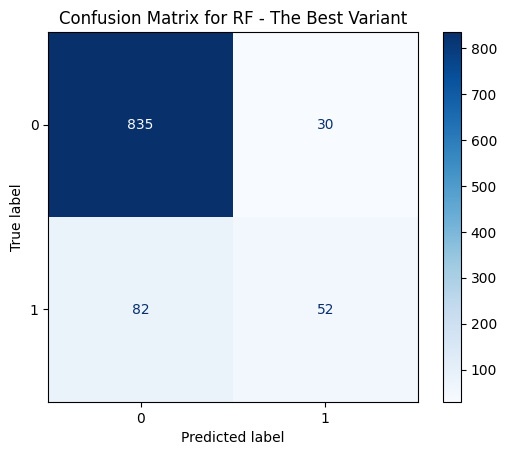

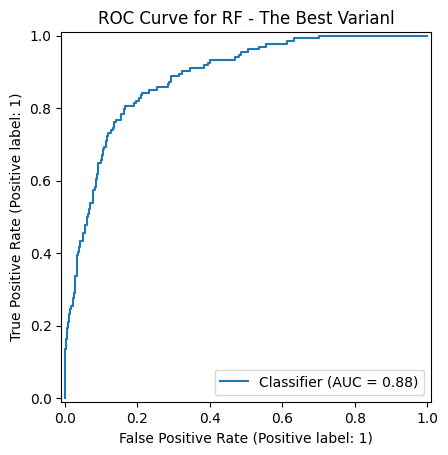

Model zapisany jako: RF_results/rf_model.joblib


In [11]:
run_pipeline("v1_training_variant3_full.csv", "v1_test_variant3_full.csv", smote=True)